# SAM3 Dense Tracking (Single-GPU)

## 1. Setup

In [1]:
sam3_root = "/home/kalyanv/sam3"
# checkpoint_file = f"{sam3_root}/assets/checkpoints/prod_v12_sam2_internal_shared_dth0.5_newdet0.7_assth0.1_nms0.1.pt"
checkpoint_file = f"{sam3_root}/assets/checkpoints/sam3_prod_v12_video.pt"
bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"


In [4]:
import os
import random
import sys
from glob import glob
from sam3.model.sam3_model_web import Sam3Model
from sam3.model.sam3_model_web_multigpu import Sam3ModelMultiGPU

GPUS_TO_USE = [0, 1, 2, 3, 4, 5, 6, 7]
# set the GPUs to use via "CUDA_VISIBLE_DEVICES"
assert all(isinstance(i, int) for i in GPUS_TO_USE)
assert GPUS_TO_USE == sorted(set(GPUS_TO_USE))
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(str(i) for i in GPUS_TO_USE)


model_wrapper = Sam3ModelMultiGPU( # use Sam3Model for running on single GPU
    bpe_path=bpe_path,
    checkpoint_path=checkpoint_file,
    strict_state_dict_loading=True,
)

INFO:sam3.model.sam3_model_web_multigpu:setting up MultiGPU inference with AVAILABLE_GPUS=[0, 1, 2, 3, 4, 5, 6, 7]
INFO:sam3.model.sam3_model_web_multigpu:loading model on rank=0 with world_size=8 -- this could take a while ...
INFO:root:Using points (sampled from masks) as inputs
INFO:sam3.model.sam3_dense_shared_multigpu:`setting max_num_objects` to 128 -- creating num_obj_for_compile=16 objects for torch.compile cache
INFO:sam3.model.sam3_model_web_multigpu:loading model on rank=0 with world_size=8 -- DONE locally
INFO:sam3.model.sam3_model_web_multigpu:spawning 8 worker processes
INFO:sam3.model.sam3_model_web_multigpu:preparing to spawn worker process rank=1 with world_size=8 with env vars: os.environ['RANK']='1', os.environ['WORLD_SIZE']='8', os.environ['CUDA_VISIBLE_DEVICES']='1'
INFO:sam3.model.sam3_model_web_multigpu:preparing to spawn worker process rank=2 with world_size=8 with env vars: os.environ['RANK']='2', os.environ['WORLD_SIZE']='8', os.environ['CUDA_VISIBLE_DEVICES']

### Visualization utils

In [5]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pprint
import cv2
import subprocess
import torch
from matplotlib.colors import to_rgb
from matplotlib.patches import Rectangle
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
from sklearn.cluster import KMeans
from tqdm import tqdm
from sam3.model.data_misc import recursive_to, interpolate
from torchvision.ops import masks_to_boxes


def generate_colors(n_colors=256, n_samples=5000):
    # Step 1: Random RGB samples
    np.random.seed(42)
    rgb = np.random.rand(n_samples, 3)
    # Step 2: Convert to LAB for perceptual uniformity
    print(f"Converting {n_samples} RGB samples to LAB color space...")
    lab = rgb2lab(rgb.reshape(1, -1, 3)).reshape(-1, 3)
    print("Conversion to LAB complete.")
    # Step 3: k-means clustering in LAB
    kmeans = KMeans(n_clusters=n_colors, n_init=10)
    print(f"Fitting KMeans with {n_colors} clusters on {n_samples} samples...")
    kmeans.fit(lab)
    print("KMeans fitting complete.")
    centers_lab = kmeans.cluster_centers_
    # Step 4: Convert LAB back to RGB
    colors_rgb = lab2rgb(centers_lab.reshape(1, -1, 3)).reshape(-1, 3)
    colors_rgb = np.clip(colors_rgb, 0, 1)
    return colors_rgb


COLORS = generate_colors(n_colors=128, n_samples=5000)


def show_img_tensor(img_batch, vis_img_idx=0):
    MEAN_IMG = np.array([0.485, 0.456, 0.406])
    STD_IMG = np.array([0.229, 0.224, 0.225])
    im_tensor = img_batch[vis_img_idx].detach().cpu()
    assert im_tensor.dim() == 3
    im_tensor = im_tensor.numpy().transpose((1, 2, 0))
    im_tensor = (im_tensor * STD_IMG) + MEAN_IMG
    im_tensor = np.clip(im_tensor, 0, 1)
    plt.imshow(im_tensor)


def show_points_with_labels(coords, labels, ax=None, marker_size=200):
    if ax is None:
        ax = plt.gca()
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker="*", s=marker_size, edgecolor="white", linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker="*", s=marker_size, edgecolor="white", linewidth=1.25)


def plot_bbox(
    img_height,
    img_width,
    box,
    box_format="XYXY",
    relative_coords=True,
    color="r",
    linestyle="solid",
    text=None,
    ax=None,
):
    if box_format == "XYXY":
        x, y, x2, y2 = box
        w = x2 - x
        h = y2 - y
    elif box_format == "XYWH":
        x, y, w, h = box
    elif box_format == "CxCyWH":
        cx, cy, w, h = box
        x = cx - w / 2
        y = cy - h / 2
    else:
        raise RuntimeError(f"Invalid box_format {box_format}")

    if relative_coords:
        x *= img_width
        w *= img_width
        y *= img_height
        h *= img_height

    if ax is None:
        ax = plt.gca()
    rect = patches.Rectangle(
        (x, y), w, h, linewidth=1.5, edgecolor=color, facecolor="none", linestyle=linestyle,
    )
    ax.add_patch(rect)
    if text is not None:
        facecolor = "w"
        ax.text(
            x, y - 5, text, color=color, weight="bold", fontsize=8,
            bbox={"facecolor": facecolor, "alpha": 0.75, "pad": 2},
        )


def plot_mask(mask, color="r", ax=None):
    im_h, im_w = mask.shape
    mask_img = np.zeros((im_h, im_w, 4), dtype=np.float32)
    mask_img[..., :3] = to_rgb(color)
    mask_img[..., 3] = mask * 0.5
    # Use the provided ax or the current axis
    if ax is None:
        ax = plt.gca()
    ax.imshow(mask_img)


def normalize_bbox(bbox_xyxy, img_w, img_h):
    bbox_xyxy[0], bbox_xyxy[2] = bbox_xyxy[0] / img_w, bbox_xyxy[2] / img_w
    bbox_xyxy[1], bbox_xyxy[3] = bbox_xyxy[1] / img_h, bbox_xyxy[3] / img_h
    return bbox_xyxy

def visualize_frame_output(frame_idx, image_files, outputs, figsize=(12, 8)):
    plt.figure(figsize=figsize)
    plt.title(f"frame {frame_idx}")
    img = plt.imread(image_files[frame_idx])
    img_H, img_W, _ = img.shape
    plt.imshow(img)
    for i in range(len(outputs["out_probs"])):
        box_xywh = outputs["out_boxes_xywh"][i]
        prob = outputs["out_probs"][i]
        obj_id = outputs["out_obj_ids"][i]
        binary_mask = outputs["out_binary_masks"][i]
        color = COLORS[obj_id % len(COLORS)]
        plot_bbox(img_H, img_W, box_xywh, text=f"(id={obj_id}, {prob=:.2f})", box_format="XYWH", color=color)
        plot_mask(binary_mask, color=color)


def visualize_formatted_frame_output(frame_idx, image_files, outputs_list, titles=None, points_list=None, points_labels_list=None, figsize=(12, 8)):
    """Visualize up to three sets of segmentation masks on a video frame.

    outputs_list: List of {frame_idx: {obj_id: mask_tensor}}
    titles: List of titles for each set of outputs_list
    """
    num_outputs = len(outputs_list)
    if titles is None:
        titles = [f"Set {i+1}" for i in range(num_outputs)]
    assert len(titles) == num_outputs, "length of `titles` should match that of `outputs_list` if not None."

    fig, axes = plt.subplots(1, num_outputs, figsize=figsize)
    if num_outputs == 1:
        axes = [axes]  # Make it iterable
    img = plt.imread(image_files[frame_idx])
    img_H, img_W, _ = img.shape
    for idx in range(num_outputs):
        ax, outputs_set, ax_title = axes[idx], outputs_list[idx], titles[idx]
        ax.set_title(f"Frame {frame_idx} - {ax_title}")
        ax.imshow(img)
        _outputs = outputs_set[frame_idx]
        for obj_id, binary_mask in _outputs.items():
            box_xyxy = masks_to_boxes(torch.tensor(binary_mask).unsqueeze(0)).squeeze()
            box_xyxy = normalize_bbox(box_xyxy, img_W, img_H)
            color = COLORS[obj_id % len(COLORS)]
            plot_bbox(img_H, img_W, box_xyxy, text=f"(id={obj_id})", box_format="XYXY", color=color, ax=ax)
            plot_mask(binary_mask, color=color, ax=ax)

        # points
        if points_list is not None and points_list[idx] is not None:
            show_points_with_labels(points_list[idx], points_labels_list[idx], ax=ax, marker_size=200)

    plt.tight_layout()
    plt.show()


def render_masklet_frame(img, outputs, frame_idx=None, alpha=0.5):
    """
    Overlays masklets and bounding boxes on a single image frame.
    Args:
        img: np.ndarray, shape (H, W, 3), uint8 or float32 in [0,255] or [0,1]
        outputs: dict with keys: out_boxes_xywh, out_probs, out_obj_ids, out_binary_masks
        frame_idx: int or None, for overlaying frame index text
        alpha: float, mask overlay alpha
    Returns:
        overlay: np.ndarray, shape (H, W, 3), uint8
    """
    if img.dtype == np.float32 or img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    img = img[..., :3]  # drop alpha if present
    height, width = img.shape[:2]
    overlay = img.copy()

    for i in range(len(outputs["out_probs"])):
        obj_id = outputs["out_obj_ids"][i]
        color = COLORS[obj_id % len(COLORS)]
        color255 = (color * 255).astype(np.uint8)
        mask = outputs["out_binary_masks"][i]
        if mask.shape != img.shape[:2]:
            mask = cv2.resize(mask.astype(np.float32), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        mask_bool = mask > 0.5
        for c in range(3):
            overlay[..., c][mask_bool] = (
                alpha * color255[c] + (1 - alpha) * overlay[..., c][mask_bool]
            ).astype(np.uint8)

    # Draw bounding boxes and text
    for i in range(len(outputs["out_probs"])):
        box_xywh = outputs["out_boxes_xywh"][i]
        obj_id = outputs["out_obj_ids"][i]
        prob = outputs["out_probs"][i]
        color = COLORS[obj_id % len(COLORS)]
        color255 = tuple(int(x * 255) for x in color)
        x, y, w, h = box_xywh
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
        cv2.rectangle(overlay, (x1, y1), (x2, y2), color255, 2)
        label = f"id={obj_id}, p={prob:.2f}"
        cv2.putText(
            overlay, label, (x1, max(y1 - 10, 0)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color255, 1, cv2.LINE_AA
        )

    # Overlay frame index at the top-left corner
    if frame_idx is not None:
        cv2.putText(
            overlay, f"Frame {frame_idx}", (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2, cv2.LINE_AA
        )

    return overlay


def save_masklet_video(image_files, outputs, out_path, alpha=0.5, fps=10):
    # Each outputs dict has keys: "out_boxes_xywh", "out_probs", "out_obj_ids", "out_binary_masks"
    # image_files: list of image file paths, same length as outputs_list

    # Read first frame to get size
    first_img = plt.imread(image_files[0])
    height, width = first_img.shape[:2]
    if first_img.dtype == np.float32 or first_img.max() <= 1.0:
        first_img = (first_img * 255).astype(np.uint8)
    # Use 'mp4v' for best compatibility with VSCode playback (.mp4 files)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter('temp.mp4', fourcc, fps, (width, height))

    outputs_list = [(image_files[frame_idx], frame_idx, outputs[frame_idx]) for frame_idx in sorted(outputs.keys())]

    for img_path, frame_idx, frame_outputs in tqdm(outputs_list):
        img = plt.imread(img_path)
        overlay = render_masklet_frame(img, frame_outputs, frame_idx=frame_idx, alpha=alpha)
        writer.write(cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    writer.release()

    # Re-encode the video for VSCode compatibility using ffmpeg
    subprocess.run(["ffmpeg", "-y", "-i", 'temp.mp4', out_path])
    print(f"Re-encoded video saved to {out_path}")

    os.remove('temp.mp4')  # Clean up temporary file


def save_masklet_image(image_file, outputs, out_path, alpha=0.5, frame_idx=None):
    '''
    Save a single image with masklet overlays.
    '''
    img = plt.imread(image_file)
    overlay = render_masklet_frame(img, outputs, frame_idx=frame_idx, alpha=alpha)
    Image.fromarray(overlay).save(out_path)
    print(f"Overlay image saved to {out_path}")


def prepare_masks_for_visualization(frame_to_output):
    # frame_to_obj_masks --> {frame_idx: {'output_probs': np.array, `out_obj_ids`: np.array, `out_binary_masks`: np.array}}
    for frame_idx, out in frame_to_output.items():
        _processed_out = {}
        for idx, obj_id in enumerate(out["out_obj_ids"].tolist()):
            if out["out_binary_masks"][idx].any():
                _processed_out[obj_id] = out["out_binary_masks"][idx]
        frame_to_output[frame_idx] = _processed_out
    return frame_to_output

Bad key keymap.all_axes in file /tmp/par_unpack.bento_cloud.168753.32f660d2d07e6aba3eeeb6075d7f1efc/bento/server/matplotlibrc-3.1.3, line 76 ('keymap.all_axes : a                 # enable all axes')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.6/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


Converting 5000 RGB samples to LAB color space...
Conversion to LAB complete.
Fitting KMeans with 128 clusters on 5000 samples...


KMeans fitting complete.


## 2. Running inference

In [6]:
# this video has 6 objects
video_frames_dir = f"{sam3_root}/assets/videos/0001"
prompt_text_str = "person"

# this video has ~80 objects
# video_frames_dir = "/checkpoint/sam3/shared/webdemo/data/ta/static/gallery/selected_examples/0018/rgb"
# prompt_text_str = "horse"

### Opening an inference session on this video

In [7]:
response = model_wrapper.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_frames_dir,
    )
)
session_id = response["session_id"]

# "image_files" is only needed for visualization purposes (not used by the model)
image_files = glob(os.path.join(video_frames_dir, "*.jpg"))
try:
    # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
    image_files.sort(key=lambda p: int(os.path.splitext(os.path.basename(p))[0]))
except ValueError:
    # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
    print(
        f'frame names are not in "<frame_index>.jpg" format: {image_files[:5]=}, '
        f"falling back to lexicographic sort."
    )
    image_files.sort()

frame loading (JPEG):  40%|████      | 109/270 [00:28<00:46,  3.49it/s]

### Adding a text prompt on frame 0 and propagation throughout the video

Note that the first call might be slower due to setting up buffers. **You can rerun all the cells below when measuring speed.**

In [8]:
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = model_wrapper.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

INFO:sam3.model.sam3_model_web:clear all inputs across the video in session 53e0e4f3-eb22-4770-8e36-85666c759626


In [9]:
frame_idx = 0  # add a text prompt on frame 0
response = model_wrapper.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
out = response["outputs"]

INFO:sam3.model.sam3_model_web:add prompt on frame 0 in session 53e0e4f3-eb22-4770-8e36-85666c759626: text='person', points=None, point_labels=None, clear_old_points=None, bounding_boxes=None, bounding_box_labels=None, clear_old_boxes=None
INFO:sam3.model.sam3_demo_dense_tracking_multigpu:Running add_prompt on frame 0
/home/kalyanv/miniconda/envs/sam3/lib/python3.12/site-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/storage/home/kalyanv/sam3/sam3/model/decoder.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/kalyanv/miniconda/envs/sam3/lib/python3.12/site-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample a

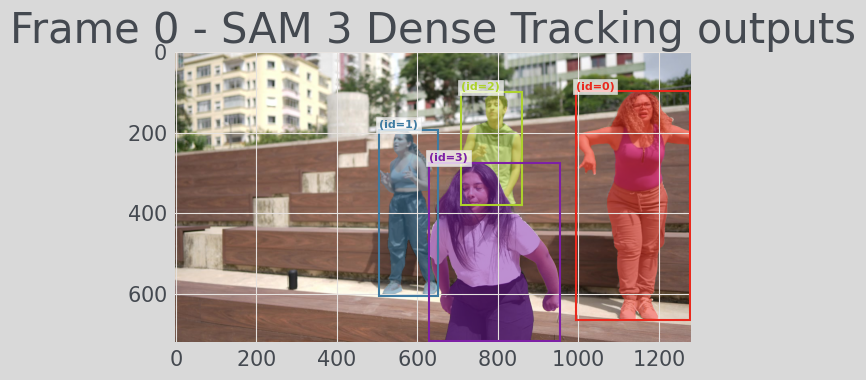

In [10]:
plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    image_files,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

In [11]:
# we will just propagate from frame 0 to the end of the video
outputs_per_frame = {}
for response in model_wrapper.handle_stream_request(
    request=dict(
        type="propagate_in_video",
        session_id=session_id,
    )
):
    outputs_per_frame[response["frame_index"]] = response["outputs"]
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

INFO:sam3.model.sam3_model_web:propagate in video in session 53e0e4f3-eb22-4770-8e36-85666c759626: propagation_direction='both', start_frame_idx=None, max_frame_num_to_track=None

propagate_in_video:   3%|▎         | 8/270 [00:00<00:21, 12.05it/s]WARNING:root:Falling back to CPU mask NMS implementation -- please install `torch_generic_nms` via
	pip uninstall -y torch_generic_nms; TORCH_CUDA_ARCH_LIST="8.0 9.0" pip install git+https://github.com/ronghanghu/torch_generic_nms
	pip uninstall -y torch_generic_nms; TORCH_CUDA_ARCH_LIST="8.0 9.0" pip install git+https://github.com/ronghanghu/torch_generic_nms
	pip uninstall -y torch_generic_nms; TORCH_CUDA_ARCH_LIST="8.0 9.0" pip install git+https://github.com/ronghanghu/torch_generic_nms
	pip uninstall -y torch_generic_nms; TORCH_CUDA_ARCH_LIST="8.0 9.0" pip install git+https://github.com/ronghanghu/torch_generic_nms
	pip uninstall -y torch_generic_nms; TORCH_CUDA_ARCH_LIST="8.0 9.0" pip install git+https://github.com/ronghanghu/torch_generi

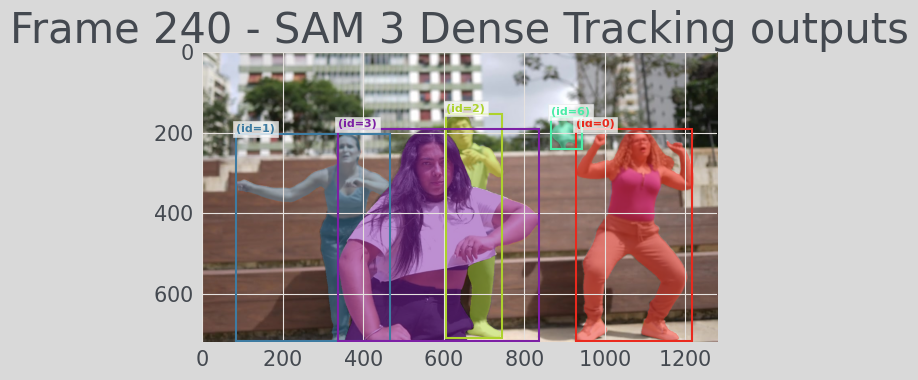

In [12]:
vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    print(f"frame {frame_idx}")
    visualize_formatted_frame_output(
        frame_idx,
        image_files,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )
